## Introduction
Exploratory analysis notebook inspired in the automatically-generated kernel from Kaggle.

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`.

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [64]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [65]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [66]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [67]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check the data file: /kaggle/input/16PF/data.csv

In [8]:
data = pd.read_csv("data.csv", sep="\t")

Let's take a quick look at what the data looks like:

In [9]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P7,P8,P9,P10,age,gender,accuracy,country,source,elapsed
0,1,4,2,3,3,2,3,4,4,3,...,1,2,5,2,17,1,92,US,6,914
1,4,3,4,3,4,4,4,4,2,2,...,3,2,2,2,37,1,100,US,1,891
2,3,4,4,4,4,4,4,3,2,2,...,2,3,3,3,31,1,80,US,6,903
3,4,5,4,4,4,3,3,2,2,2,...,2,3,4,4,32,1,93,US,1,806
4,4,0,4,4,4,3,5,1,2,4,...,4,2,3,2,46,2,87,NZ,1,1826


In [10]:
data.shape

(49159, 169)

## Dataset breakdown in factors and positive and negatively keyed questions

This personality test consists of 164 statements about the subject, for each indicate how accurate it is on the scale of (1) disagree (2) slightly disagree (3) niether agree nor disagree (4) slightly agree (5) agree.

Sources: codebook and [IPIP](https://ipip.ori.org/new16pfkey.htm)



In [13]:
positive_questions = [ # positive questions adding to the trait.
    "A1", "A2", "A3", "A4", "A5", "A6", "A7",       # Factor A: WARMTH 
    "B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", # Factor B: REASONING (Intellect)
    "C1", "C2", "C3", "C4", "C5",                   # Factor C: EMOTIONAL STABILITY
    "D1", "D2", "D3", "D4", "D5", "D6",             # Factor D: DOMINANCE (Assertiveness)
    "E1", "E2", "E3", "E4", "E5", "E6",             # Factor F: GREGARIOUSNESS (Liveliness)
    "F1", "F2", "F3", "F4", "F5",                   # Factor G: DUTIFULNESS (Rule-Consciousness)
    "G1", "G2", "G3", "G4", "G5",                   # Factor H: FRIENDLINESS (Social boldness)
    "H1", "H2", "H3", "H4", "H5", "H6",             # Factor I: SENSITIVITY
    "I1", "I2", "I3", "I4", "I5", "I6",             # Factor L: DISTRUST (Vigilance)
    "J1", "J2", "J3", "J4", "J5", "J6", "J7",       # Factor M: IMAGINATION (Abstractness)
    "K1", "K2", "K3", "K4", "K5",                   # Factor N: RESERVE (Privateness)
    "L1", "L2", "L3", "L4", "L5", "L6", "L7",       # Factor O: ANXIETY (Apprehension)
    "M1", "M2", "M3", "M4", "M5",                   # Factor Q1: COMPLEXITY (Openness to change)
    "N1", "N2", "N3", "N4", "N5", "N6", "N7",       # Factor Q2: INTROVERSION (Self-Reliance)
    "O1", "O2", "O3", "O4", "O5",                   # Factor Q3: ORDERLINESS (Perfectionism)
    "P1", "P2", "P3", "P4", "P5", "P6", "P7",       # Factor Q4: EMOTIONALITY (Tension)
]

negative_questions = [ # negative questions substracting to the trait
    "A8", "A9", "A10",                              # Factor A: WARMTH 
    "B9", "B10", "B11", "B12", "B13",               # Factor B: REASONING (Intellect)
    "C6", "C7", "C8", "C9", "C10",                  # Factor C: EMOTIONAL STABILITY
    "D7", "D8", "D9", "D10",                        # Factor D: DOMINANCE (Assertiveness)
    "E7", "E8", "E9", "E10",                        # Factor F: GREGARIOUSNESS (Liveliness)
    "F6", "F7", "F8", "F9", "F10",                  # Factor G: DUTIFULNESS (Rule-Consciousness)
    "G6", "G7", "G8", "G9", "G10",                  # Factor H: FRIENDLINESS (Social boldness)
    "H7", "H8", "H9", "H10",                        # Factor I: SENSITIVITY
    "I7", "I8", "I9", "I10",                        # Factor L: DISTRUST (Vigilance)
    "J8", "J9", "J10",                              # Factor M: IMAGINATION (Abstractness)
    "K6", "K7", "K8", "K9", "K10",                  # Factor N: RESERVE (Privateness)
    "L8", "L9", "L10",                              # Factor O: ANXIETY (Apprehension)
    "M6", "M7", "M8", "M9", "M10",                  # Factor Q1: COMPLEXITY (Openness to change)
    "N8", "N9", "N10",                              # Factor Q2: INTROVERSION (Self-Reliance)
    "O6", "O7", "O8", "O9", "O10",                  # Factor Q3: ORDERLINESS (Perfectionism)
    "P8", "P9", "P10"                                    # Factor Q4: EMOTIONALITY (Tension)
]

print(f"Total items in questionnaire: {len(positive_questions) + len(negative_questions)}")

Total items in questionnaire: 163


In [33]:
df = data.copy()
df.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P6,P7,P8,P9,P10,age,gender,accuracy,source,elapsed
count,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,...,49159.000000,49159.000000,49159.000000,49159.000000,49159.000000,4.915900e+04,49159.000000,4.915900e+04,49159.000000,4.915900e+04
mean,3.649566,3.791513,3.799121,3.633495,3.828495,3.670376,3.869871,2.960658,2.140463,2.428853,...,3.095486,2.796823,2.931020,3.643829,3.463964,4.371320e+04,1.600195,4.764119e+04,2.853475,2.506205e+03
std,1.140966,1.059120,1.104136,1.067361,0.992537,0.976063,0.964952,1.165763,1.043318,1.079312,...,1.155755,1.169098,1.209906,1.103671,1.119474,9.685640e+06,0.510921,9.704611e+06,2.223037,5.082819e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000e+01,0.000000,1.000000e+00,1.000000,5.000000e+00
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,2.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,1.800000e+01,1.000000,8.500000e+01,1.000000,5.840000e+02
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,2.000000,...,3.000000,3.000000,3.000000,4.000000,4.000000,2.100000e+01,2.000000,9.000000e+01,2.000000,7.540000e+02
75%,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000e+01,2.000000,9.700000e+01,6.000000,1.045000e+03
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,2.147484e+09,3.000000,2.147484e+09,6.000000,8.534589e+06


In [34]:
# Normalize according to semantic meaning
df[positive_questions] = df[positive_questions].replace({0: -2.5, 1: -1.5, 3: 0.5, 4: 1.5, 5: 2.5})
df[negative_questions] = df[negative_questions].replace({0: 2.5, 1: 1.5, 3: 0.5, 4: -1.5, 5: -2.5})

In [28]:
from string import ascii_uppercase

traits = [ascii_uppercase[i] for i in range(16)]
trait_labels = ["Warmth", "Reasoning", "Emotional stability", "Dominance", 
                "Liveliness", "Rule-consciousness", "Friendliness", "Sensitivity", 
                "Vigilance", "Abstractedness", "Privateness", "Apprehension",
                "Openness to change", "Self-reliance", "Perfectionism", "Tension"]


In [36]:
# Histogram of traits:

for trait in traits:
    trait_cols = sorted([col for col in df.columns if trait in col])
    df[trait] = df[trait_cols].sum(axis=1)
    
df[traits].head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,3.0,23.0,9.0,11.5,4.0,-3.0,2.5,11.5,8.0,22.5,4.0,6.5,14.0,10.0,5.5,13.0
1,11.0,16.5,-1.0,13.0,8.0,7.5,12.5,12.0,16.5,17.5,11.0,11.5,17.0,17.0,8.0,15.5
2,14.0,24.0,10.0,10.0,-1.0,5.0,1.0,11.0,7.0,14.0,10.0,8.5,16.5,13.0,6.0,11.5
3,15.5,16.5,8.5,7.0,11.5,1.5,11.0,14.5,10.0,20.0,8.5,10.0,14.0,19.0,-1.0,9.0
4,8.5,16.5,4.0,15.0,-2.0,8.5,14.0,8.0,14.0,5.5,9.5,13.5,18.0,9.5,11.0,12.0


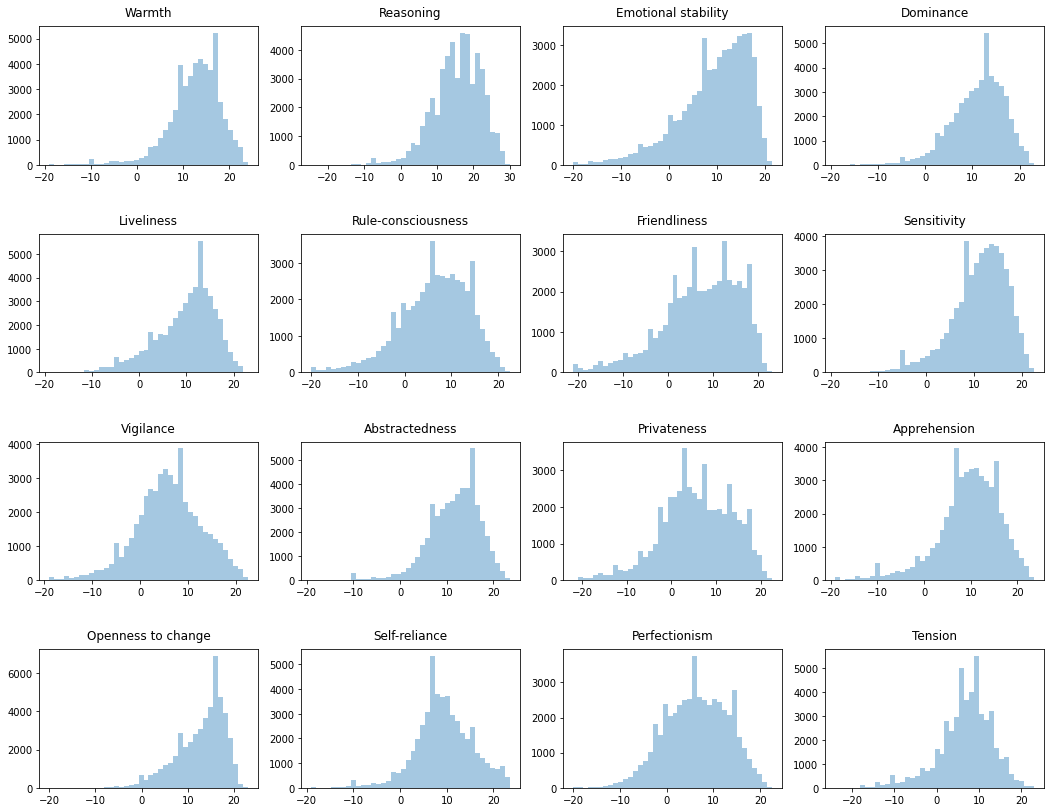

In [57]:
import seaborn as sns
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(18,9))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.3, wspace=None, hspace=0.5)
row = -1
for i, (trait, label) in enumerate(zip(traits, trait_labels)):
    if not i % 4:
        row += 1
        col = 0
    else:
        col += 1
    sns.distplot(df[trait], ax=axs[row][col], axlabel='', kde=False, bins=40).set_title(label, pad=10)

Distribution graphs (histogram/bar graph) of sampled columns:

In [76]:
# Correlations
df_traits = df[traits].rename(columns={k: v for k, v in zip(traits, trait_labels)})
df_traits.corr()
df_traits.dataframeName = "Normalized 16PF scores"

In [77]:
# plotPerColumnDistribution(data, 10, 5)

Correlation matrix:

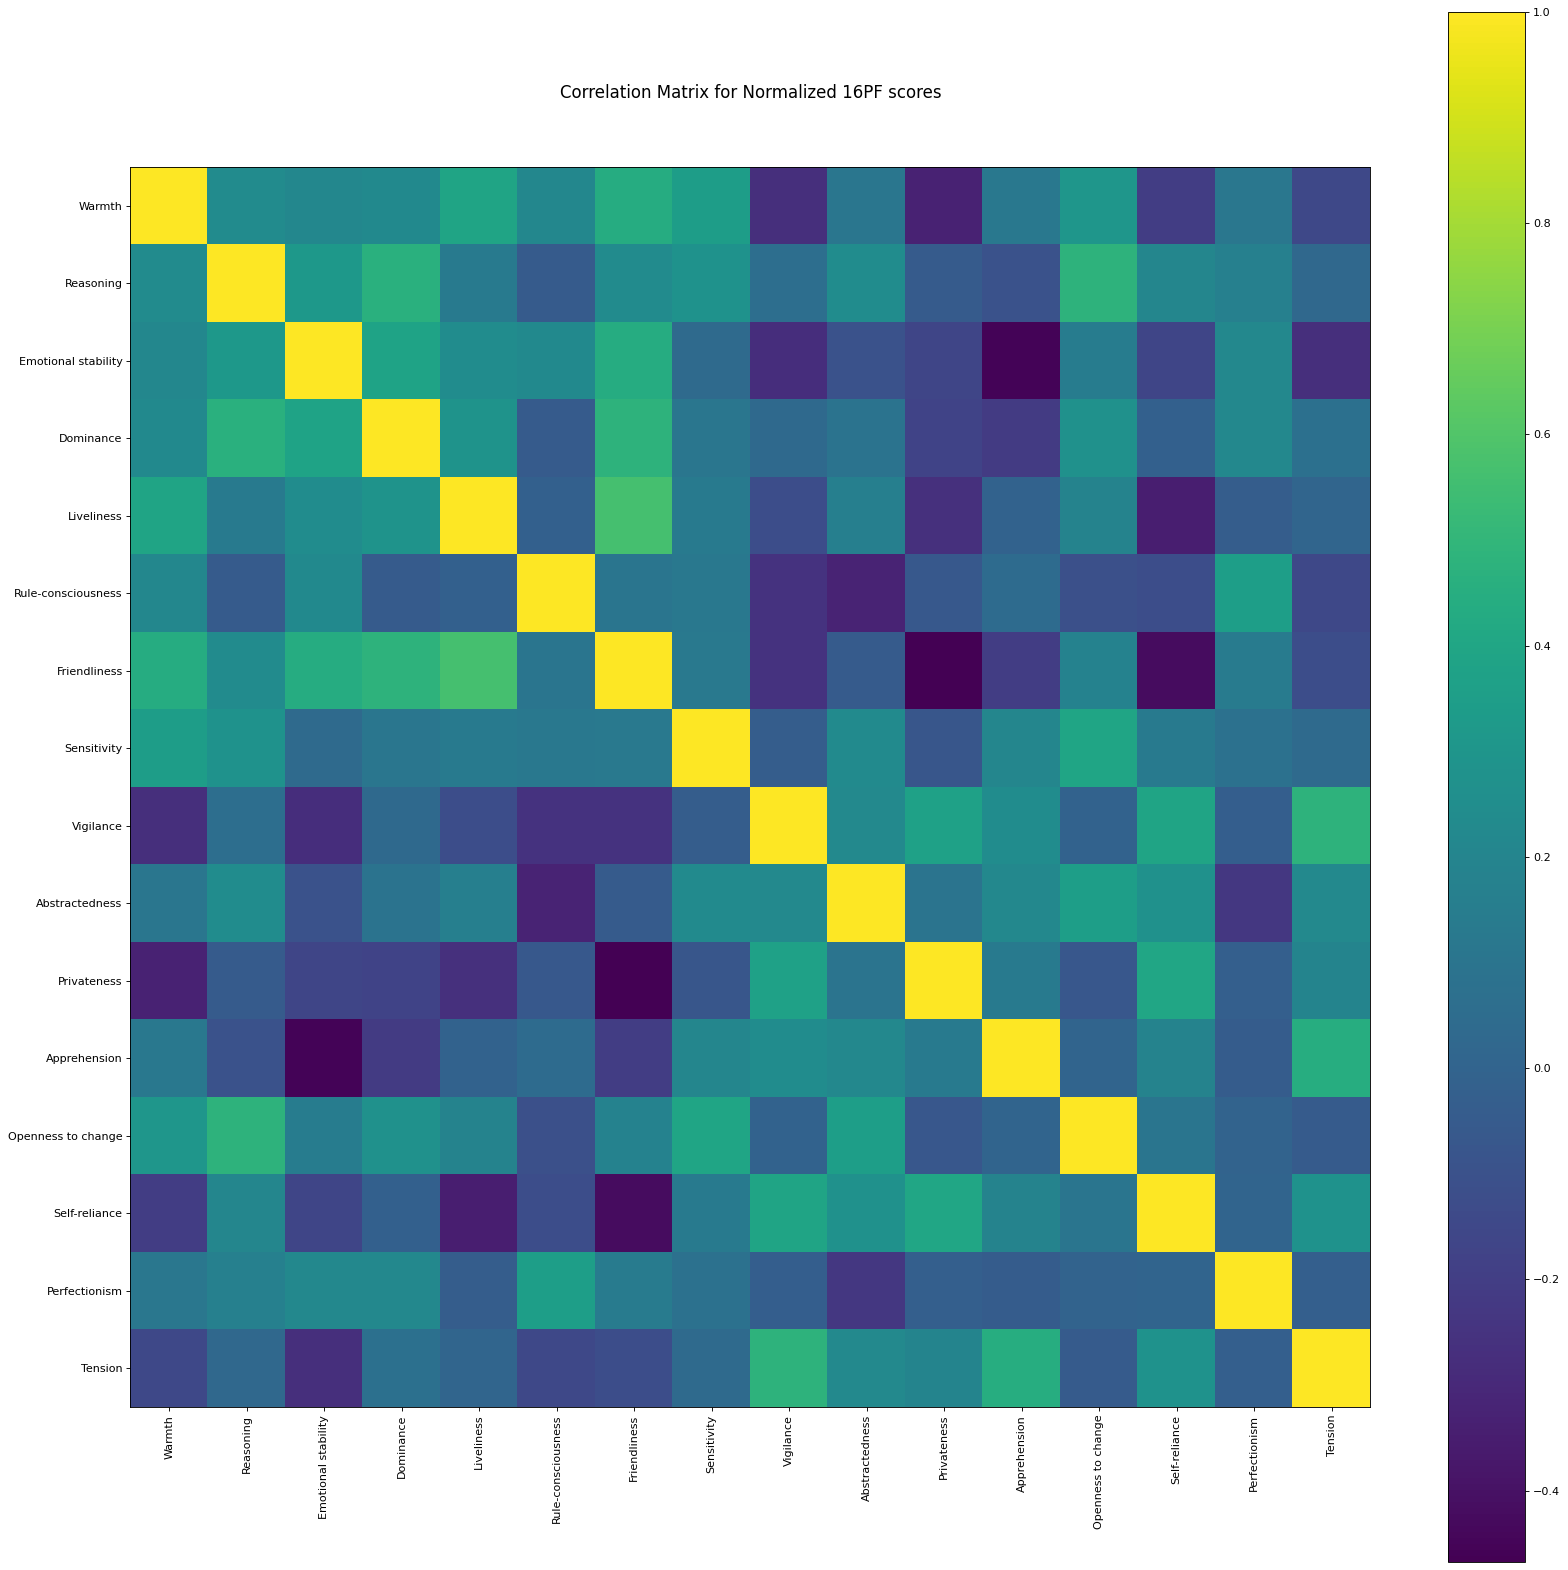

In [78]:
plotCorrelationMatrix(df_traits, 25)

Scatter and density plots:

In [ ]:
# plotScatterMatrix(data, 20, 10)

## Conclusion
